<a href="https://colab.research.google.com/github/techshot25/California-Housing/blob/master/California-Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering California Housing with K-means
### By Ali Shannon

I am looking into the housing crisis in the state of California. This dataset is kindly provided by [Kaggle](https://www.kaggle.com/camnugent/california-housing-prices), visit their website for free datasets for machine learning and AI training.


"Tonight, more than 130,000 Californians will go to sleep homeless. That’s enough to fill Dodger Stadium, AT&T Park and Petco Park. The biggest culprit is rising housing costs. From 2000 to 2014, median rent in California increased by more than one-third, while real incomes for renters fell by 7 percent. Today, 1.5 million Californians spend more than half their income on housing. This crisis threatens not just low-income families but our entire economy, driving businesses to relocate to states in which their employees can afford to live. - **Business Insider, Sep 2018.**"

![Half of the homes in San Franciso is now one million or above](https://amp.businessinsider.com/images/573de0b88d3eaea27198a55d-960-480.jpg)

I will attempt to cluster the dataset using K-Means, the most popular clustering algorithm in machine learning. The idea here is to find the best number of clusters that minimizes the objective function I declare below.

---

## 1. PRE-PROCESSING THE DATA

Here, I will show some statistical information and do some preprocessing before applying machine learning algorithms.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

np.random.seed(42)

df = pd.read_csv('housing.csv')

df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Basic distributions for each column.

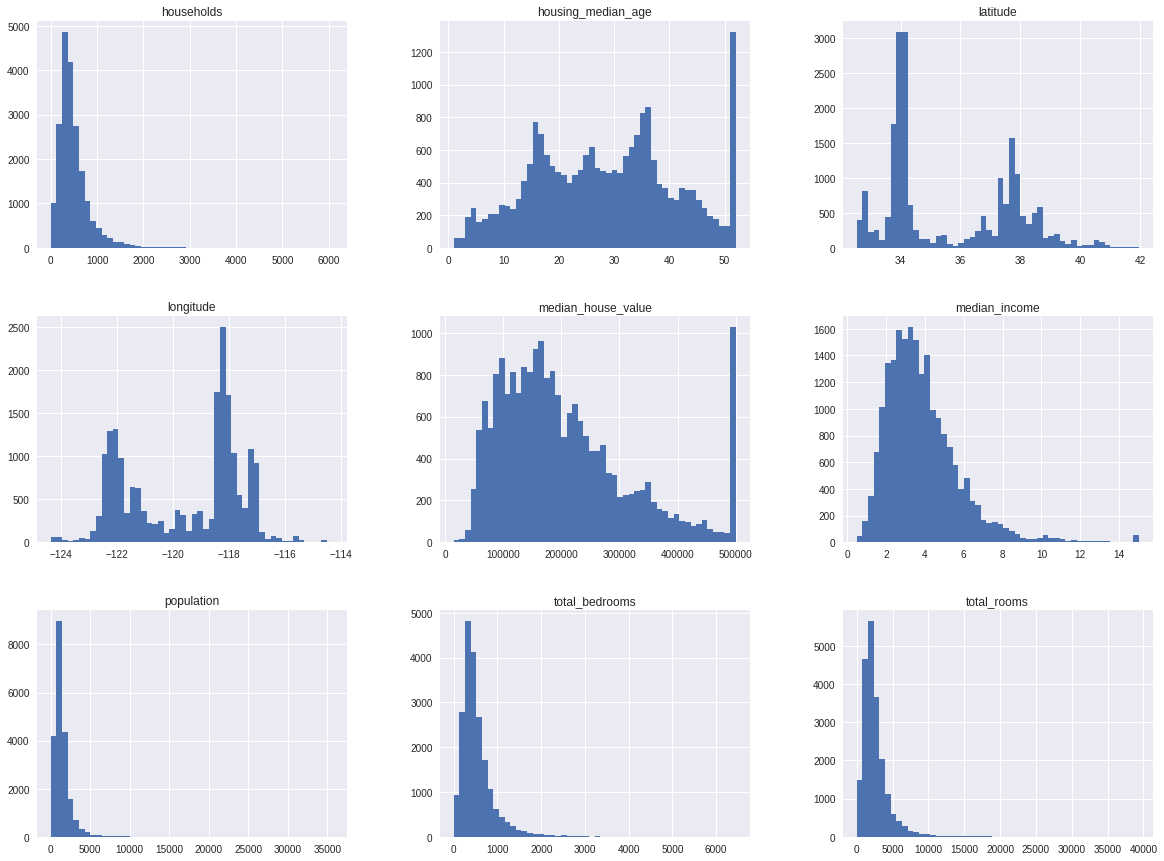

In [0]:
df.hist(bins=50, figsize=(20,15));
plt.show()

Notice the latitude and longitude of density of homes near Los Angeles and San Francisco areas. This might be useful for our clustering algorithm.

---

This is an image showing the distribution of houses from the dataset. The size of the circles indicate the population density and the color indicates the median house value.

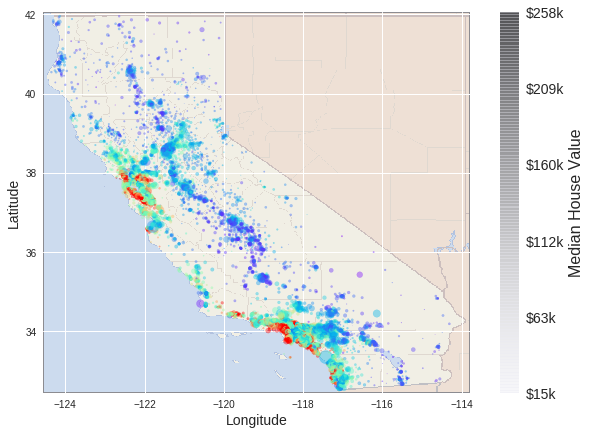

In [0]:
cali_image_url = 'https://upload.wikimedia.org/wikipedia/commons/1/1b/California_Locator_Map.PNG'
cali = plt.imread(cali_image_url)

# plot the populations with density and colors
ax = df.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4,
    s = df["population"]/200, figsize = (11,7),
    c = "median_house_value", cmap = plt.get_cmap("rainbow"), colorbar = False,
    sharex = True)

# show the image of California in the back
plt.imshow(cali, extent=[-124.55, -113.80, 32.45, 42.05], alpha = 0.4)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = df["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(cmap = "rainbow")
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)


plt.show()

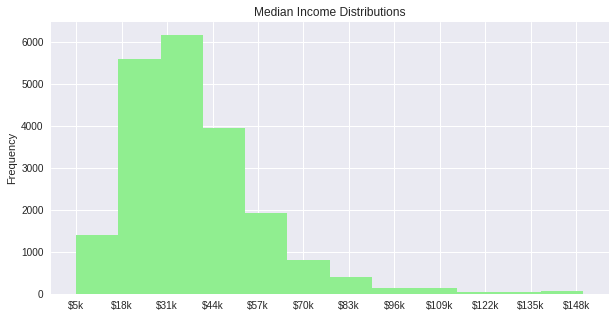

In [0]:
ran = np.arange(df['median_income'].min() ,df['median_income'].max(), 1.3)
ticks = ['${:.0f}k'.format(v*10) for v in ran]


df["median_income"].plot.hist(bins = len(ran), figsize = [10,5], color = 'lightgreen')
plt.xticks(ran, ticks)
plt.title('Median Income Distributions')
plt.show()

Find the data type of each column so we can figure out which columns we need to convert to dummies.

In [0]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [0]:
df = pd.get_dummies(df)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,1,0


Converted all fields into float or int so now we can check for missing values.

In [0]:
# check for missing values
missing_values = df.isnull().sum().sort_values(ascending = False)
missing_values = missing_values[missing_values > 0]/df.shape[0] # normalize
print(f'{missing_values *100} %')

total_bedrooms    1.002907
dtype: float64 %


About 1% of the total_bedrooms feature is missing. Let's fill out all missing values with the median for each field.

In [0]:
for feature in df.columns:
    df[feature].fillna(df[feature].median(), inplace=True)

In [0]:
df.isnull().sum()

longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms                0
population                    0
households                    0
median_income                 0
median_house_value            0
ocean_proximity_<1H OCEAN     0
ocean_proximity_INLAND        0
ocean_proximity_ISLAND        0
ocean_proximity_NEAR BAY      0
ocean_proximity_NEAR OCEAN    0
dtype: int64

- - -

## 2. IMPLEMENTING K-MEANS

The `KMeans` function takes two arguments:

- `X` is the $m\times n$ matrix that is our data.

- `k` is the number of clusters to start with.

This function will start by making `k` centroids with values randomly extracted from feature space (n-dimensional vectors).
For each instance, it will calculate the Euclidean distance to each one of the centroids and assign the closest centroid to this instance.
Then it will update the location of the centroid to the average distance of the points that belong to it.

$$\text{dist}(\textbf{x}^{[i]}, \textbf{c}^{[j]}) = \sqrt{\sum_{k=1}^{n} \left [ x^{[i]}_{k} - c^{[j]}_{k} \right ] ^{2}} = \| \textbf{x}^{[i]} - \textbf{c}^{[j]} \|$$


$$\text{for }\textit{i} \in \text{[0, m],} \text{ for }\textit{j} \in \text{[0, K]}$$

This function returns two arguments:

- `distances` the distances matrix where each sample (or instance) is included with the distances to each centroid and the closest centroid.

- `centroids` a dictionary with the location of each centroid indexed from _0 to k-1_.

In [0]:
def assignment(X, centroids):
  
  distances = []
  
  for row in X.values:
    arr = []
    for j in centroids:
      arr.append(
        # use the euclidian distances
        np.linalg.norm(row - np.array(centroids[j])) 
      )
    arr.append(np.argmin(arr)) 
    distances.append(arr)
          
  return distances

def update(X, centroids, distances):
  
  for c in centroids:
    indicies = [distances.index(row) for row in distances if row[-1] == c]
    
    # update the centroids with the means of each cluster
    centroids[c] = X.iloc[indicies].mean().values 
    
  return centroids


def KMeans(X, k):

    # initialize random centroids
        
    mins = X.min().values
    maxs = X.max().values
    
    centroids = {
        i: [np.random.uniform(mins, maxs)]
        for i in range(k)
    }
    
    distances = assignment(X, centroids)    
    
    # iterate until assignments remain within a certain tolerance
    while True:
      
      old = [x[-1] for x in distances]
    
      centroids = update(X, centroids, distances)
     
      distances = assignment(X, centroids)
      
      new = [x[-1] for x in distances]
      
      if np.allclose(old, new, 100*k, 1.0e+1):
        break
      
      
    return distances, centroids

The `J(X, K)` is the evaluation or objective function. This is intended to find the number of clusters that minimizes the rate of change of the objective function. Here I am using the elbow method to find the least number of clusters.

In [0]:
def J(X, K):
    
    means = []
    stds = []
    
    for k in range(1, K + 1):
        dist, c = KMeans(X, k)
        mean = []
        std = []
        for i in range(k):
          di = [x[i] for x in dist if x[-1] == i]
          mean.append(np.average(di))
          std.append(np.std(di))
          
        stds.append(np.mean(std))
        means.append(np.mean(mean))
        
    
    return means, stds

Attempt to find an elbow with 10 clusters. 

**NOTE** This part may be slow due to the fact that has to run through the entire dataset multiple times for the purposes of this project assignment. Please be patient until it is done. I have chosen to run it only on a random set of 5000 samples to show what happens when we increase the number of clusters.

In [0]:
K = 10

means, stds = J(df.sample(5000), K)

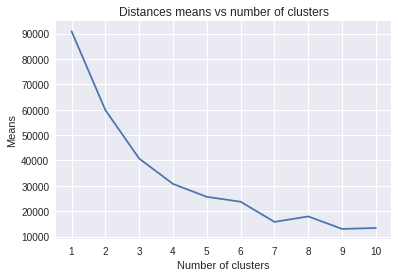

In [0]:
plt.plot(np.arange(1, K+1), means);
plt.xlabel('Number of clusters')
plt.xticks(np.arange(1, K+1))
plt.title('Distances means vs number of clusters')
plt.ylabel('Means')
plt.show()

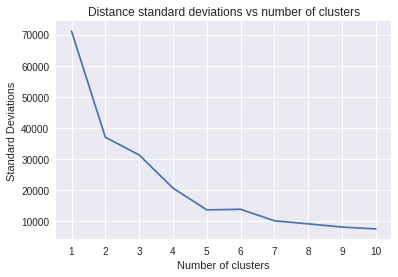

In [0]:
plt.plot(np.arange(1, K+1), stds);
plt.xlabel('Number of clusters')
plt.xticks(np.arange(1, K+1))
plt.title('Distance standard deviations vs number of clusters')
plt.ylabel('Standard Deviations')
plt.show()

Two or three clusters should have the optimal number of clusters.

- - -
## 3. CLUSTERING HOUSING INTO REGIONS

Here I attempt to split California into three regions. This assessment is based on the elbow method as described above. I will use those functions to split the region into three clusters.

In [0]:
k = 3

dist, cent = KMeans(df, k)

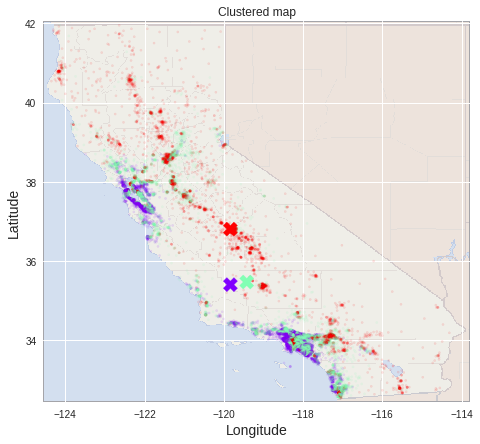

In [0]:
x, y = [cent[i][0] for i in cent], [cent[i][1] for i in cent]

df.plot(kind="scatter", x = "longitude", y = "latitude", alpha = 0.1,
    s = 5, figsize = (10,7), colorbar = False,
    c = np.array(dist)[:,-1], cmap = plt.get_cmap("rainbow"),
    sharex=False)

plt.scatter(x, y, marker='X', alpha = 1.0, c = [u for u in cent], cmap = plt.get_cmap("rainbow"), s = 200)

plt.imshow(cali, extent=[-124.55, -113.80, 32.45, 42.05], alpha = 0.3)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title('Clustered map')

plt.show()

Geometrically they seem to overlap but in reality they don't. A plot of each cluster and its housings on separate maps might look better.

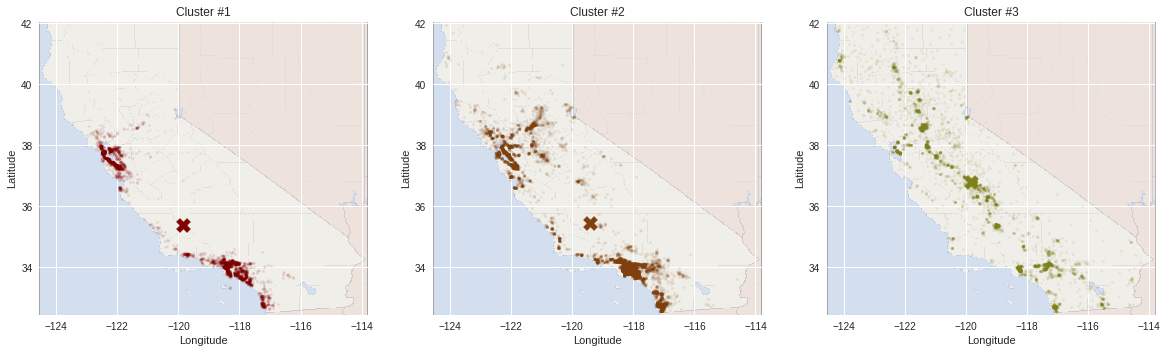

In [0]:
fig = plt.figure(figsize=(20, 30))


for c in range(k):

    ind = [dist.index(x) for x in dist if x[-1] == c]
    
    colormap = [[0.5, c / 2 / (k-1) , 0.1*(c/(k-1))]]

    
    ax = fig.add_subplot(1, k, c+1)
    ax.scatter(x = df['longitude'].iloc[ind], y = df['latitude'].iloc[ind], alpha = 0.1,
        s = 5, c = colormap)


    ax.scatter(x[c], y[c], marker='X', alpha = 1.0, c = colormap, s = 200)

    ax.imshow(cali, extent=[-124.55, -113.80, 32.45, 42.05], alpha = 0.3)
    ax.set(ylabel = "Latitude", xlabel = "Longitude", title = "Cluster #{}".format(c+1))

plt.show()

Notice that the bay area is in a cluster by itself. This is the region with highest housing prices and relatively lower bedrooms. The second cluster shows the suburban regions with higher number of bedrooms and slightly lower prices. And finally, the third region shows the rural areas around California with lower ranges of prices.

In [0]:
cols = ['Distance to cluster #{}'.format(x+1) for x in range(k)] + ['Assignments']


diss = pd.DataFrame(dist, columns=cols)

df2 = pd.concat((df, diss), axis =1)

In [0]:
from IPython import display

for c in range(k):
    s = df2[df2['Assignments'] == c].mean()
    print('\nCluster #{}\n'.format(c+1))
    display.display(s)


Cluster #1



longitude                       -119.825858
latitude                          35.394697
housing_median_age                30.843429
total_rooms                     3059.256068
total_bedrooms                   556.082222
population                      1323.486989
households                       524.169910
median_income                      5.821560
median_house_value            385531.590859
ocean_proximity_<1H OCEAN          0.557402
ocean_proximity_INLAND             0.055762
ocean_proximity_ISLAND             0.001093
ocean_proximity_NEAR BAY           0.184343
ocean_proximity_NEAR OCEAN         0.201400
Distance to cluster #1         68588.294382
Distance to cluster #2        213233.769337
Distance to cluster #3        315605.580602
Assignments                        0.000000
dtype: float64


Cluster #2



longitude                       -119.390617
latitude                          35.322094
housing_median_age                27.871947
total_rooms                     2696.816525
total_bedrooms                   561.168116
population                      1541.525444
households                       524.906088
median_income                      3.734439
median_house_value            189568.847150
ocean_proximity_<1H OCEAN          0.540618
ocean_proximity_INLAND             0.223908
ocean_proximity_ISLAND             0.000000
ocean_proximity_NEAR BAY           0.108716
ocean_proximity_NEAR OCEAN         0.126758
Distance to cluster #1        192555.551068
Distance to cluster #2         37577.250960
Distance to cluster #3        119664.779064
Assignments                        1.000000
dtype: float64


Cluster #3



longitude                       -119.715014
latitude                          36.474706
housing_median_age                28.300437
total_rooms                     2142.038220
total_bedrooms                   470.105533
population                      1275.665906
households                       425.990683
median_income                      2.454239
median_house_value             87014.260506
ocean_proximity_<1H OCEAN          0.141472
ocean_proximity_INLAND             0.737022
ocean_proximity_ISLAND             0.000000
ocean_proximity_NEAR BAY           0.051721
ocean_proximity_NEAR OCEAN         0.069785
Distance to cluster #1        295098.293405
Distance to cluster #2         85330.932966
Distance to cluster #3         23014.358292
Assignments                        2.000000
dtype: float64

The clusters seem to divide California houses by median house values, median income, and ocean proximity. This is interesting since we clearly see that houses closer to the industrial areas such as Los Angeles and San Francisco have a much higher value.


For some remote jobs, residents of cities may choose to move to suburban or rural areas since the median houses are way cheaper on average. 